In [1]:
import pandas as pd
import httpx
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import sweetviz as sv
import seaborn as sns
import causalpy as cp
import sklearn as skl
import statsmodels.tsa.filters.hp_filter as smf
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from ipyleaflet import Map, Marker, basemaps, LayersControl


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv("/Users/sofiepelvig/apartments/assets/data/bolig.csv.gzip", compression="gzip", parse_dates=["soldDate"])
df

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,change,guid,latitude,longitude,municipalityCode,estateCode,city,groupKey,canGetVR,bfEnr
0,0,"Åboulevard 35, 1. th",1960,5400000,2023-09-20 22:00:00+00:00,3,Alm. Salg,55102.040,4.0,98,...,0.000000,1E65440F-F71C-4DC0-9B4F-CFF6782EB4D6,55.684840,12.551123,147,221223,Frederiksberg C,NaN,True,184708
1,0,"Borups Alle 116, 2. th",2000,4195000,2023-09-14 22:00:00+00:00,3,Alm. Salg,52437.500,3.0,80,...,0.000000,7F866136-B56E-4BE5-8695-0E6DAD2E00B0,55.693672,12.533304,147,13582,Frederiksberg,NaN,True,175058
2,1993747,"Harsdorffsvej 4B, st. th",1874,3475000,2023-09-13 22:00:00+00:00,3,Alm. Salg,56967.215,2.0,61,...,-0.572246,6310B883-5F91-4690-BDDB-15157487458E,55.679310,12.546504,147,188935,Frederiksberg C,NaN,True,183893
3,0,"Roskildevej 53, 2. 207",2000,1250000,2023-09-13 22:00:00+00:00,3,Fam. Salg,19230.770,2.0,65,...,0.000000,583219EB-22E7-4D53-9BF0-D8786F3953CD,55.671980,12.511993,147,175566,Frederiksberg,NaN,True,184459
4,1999954,"Rådmand Steins Alle 15, 2. th",2000,3744000,2023-09-12 22:00:00+00:00,3,Alm. Salg,34990.652,4.0,107,...,0.000000,191C546B-C71B-4C89-8AED-2967AFC138C7,55.672897,12.499296,147,108524,Frederiksberg,NaN,True,186808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99206,0,"Hørsholmsgade 8, 3. tv",2200,11947874,1992-01-06 23:00:00+00:00,3,Alm. Salg,225431.580,2.0,53,...,0.000000,805A8D01-9BF6-4047-8164-4DF8324C489D,55.690900,12.543945,101,260348,København N,1.0,True,6019808
99207,0,"Hørsholmsgade 8, 4. th",2200,11947874,1992-01-06 23:00:00+00:00,3,Alm. Salg,217234.080,2.0,55,...,0.000000,3243A2DA-3BAE-493A-BFC7-F6ACAE031022,55.690900,12.543945,101,260348,København N,1.0,True,6019808
99208,0,"Hørsholmsgade 8, 4. tv",2200,11947874,1992-01-06 23:00:00+00:00,3,Alm. Salg,225431.580,2.0,53,...,0.000000,DA7226E2-F5C9-43D1-AEE6-F928CE45212E,55.690900,12.543945,101,260348,København N,1.0,True,6019808
99209,0,"Peter Fabers Gade 41, 2. th",2200,250000,1992-01-03 23:00:00+00:00,3,Alm. Salg,5000.000,2.0,50,...,0.000000,D9388837-4672-4B9A-A1FE-C65BB6397DD8,55.691830,12.556379,101,436128,København N,NaN,True,146895


In [3]:
#Sorting fam_salg away
alm_salg_df = df[df['saleType'] == 'Alm. Salg']

#Sorting apartments away that where sold for under 500.000 and above 9.000.000
alm_salg_df = alm_salg_df[(alm_salg_df['price'] > 5e5) & (alm_salg_df['price'] < 9e6)]

#Sorting apartments away that have above 5 roomes doe to the likelyhood of it being under 0.001%procent
alm_salg_df = alm_salg_df[(alm_salg_df['rooms'] < 6 )]

alm_salg_df = alm_salg_df.sort_values(by="soldDate")
alm_salg_df

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,change,guid,latitude,longitude,municipalityCode,estateCode,city,groupKey,canGetVR,bfEnr
17251,0,"Erik Menveds Vej 4, 3. tv",1965,800000,1992-01-01 23:00:00+00:00,3,Alm. Salg,8247.4230,5.0,97,...,0.000000,E3200C3D-DAF2-4913-8B4D-E64EF0415B28,55.683414,12.548503,147,29195,Frederiksberg C,1.0,True,100026395
17250,0,"Erik Menveds Vej 4, 2. th",1965,800000,1992-01-01 23:00:00+00:00,3,Alm. Salg,7339.4497,5.0,109,...,0.000000,1221F901-DEAF-4054-85E4-6946CA083656,55.683414,12.548503,147,29195,Frederiksberg C,1.0,True,100026395
17249,0,"Erik Menveds Vej 4, 2. tv",1965,800000,1992-01-01 23:00:00+00:00,3,Alm. Salg,7619.0480,4.0,105,...,0.000000,D7EFBD63-4F53-43D0-9098-C4C6495A2E0D,55.683414,12.548503,147,29195,Frederiksberg C,4.0,True,100026395
17248,0,"Erik Menveds Vej 4, st. tv",1965,800000,1992-01-01 23:00:00+00:00,3,Alm. Salg,7619.0480,5.0,105,...,0.000000,D665049D-BC24-42E4-BF9D-2A01DC3EDD18,55.683414,12.548503,147,29195,Frederiksberg C,4.0,True,100026395
17247,0,"Erik Menveds Vej 4, 1. th",1965,800000,1992-01-01 23:00:00+00:00,3,Alm. Salg,7339.4497,5.0,109,...,0.000000,E7F9AC4C-846F-4E2A-8AFE-248272DADAD9,55.683414,12.548503,147,29195,Frederiksberg C,4.0,True,100026395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17259,0,"Trekronergade 68, 1",2500,3600000,2023-09-20 22:00:00+00:00,3,Alm. Salg,48000.0000,3.0,75,...,0.000000,4A88D732-0155-417F-8CDC-C6CD01437919,55.655933,12.519941,101,792463,Valby,NaN,True,170165
17257,1981970,"Strandlodsvej 19C, 7",2300,7800000,2023-09-21 22:00:00+00:00,3,Alm. Salg,60937.5000,5.0,128,...,-2.439024,B697A6B1-15F4-499B-852E-63FF0AC98F59,55.665154,12.623071,101,24984,København S,NaN,True,130834
17256,2009076,"Klaksvigsgade 12, 1. th",2300,4725000,2023-09-21 22:00:00+00:00,3,Alm. Salg,50806.4530,2.0,93,...,-2.476780,669B6DC1-64D6-4C8B-9CF7-588EA7E6997A,55.667297,12.580413,101,1078,København S,NaN,True,104220
17254,0,"Holmbladsgade 58, 3. th",2300,3490000,2023-09-21 22:00:00+00:00,3,Alm. Salg,45324.6760,3.0,77,...,0.000000,62FF5AEA-4326-4E56-92E4-751BFACD94CB,55.665596,12.609646,101,233774,København S,NaN,True,123837


In [16]:
(alm_salg_df
  .sample(5)
  .loc[:, ["price", "rooms", "size", "soldDate"]]
  .assign(soldAge = lambda d: (d["soldDate"].dt.date - pd.to_datetime("1991-01-01")).dt.days/365)
  .loc[:,["price", "rooms", "size", "soldAge"]] 
)

,price,rooms,size,soldAge
7935,2475000,2.0,65,25.816438
5383,2725000,2.0,74,28.230137
16945,1930000,4.0,79,2.372603
44238,4300000,4.0,101,28.676712
59516,2149000,3.0,66,26.054795


In [48]:
(alm_salg_df["soldDate"] - pd.to_datetime("1991-01-01", utc=True)).dt.days/365

17251     1.000000
17250     1.000000
17249     1.000000
17248     1.000000
17247     1.000000
           ...    
17259    32.739726
17257    32.742466
17256    32.742466
17254    32.742466
17255    32.742466
Name: soldDate, Length: 68104, dtype: float64

In [49]:
train_data = (alm_salg_df
  .loc[:, ["price", "rooms", "size", "soldDate"]]
  .assign(soldAge = lambda d: (d["soldDate"] - pd.to_datetime("1991-01-01", utc=True)).dt.days/365)
  .loc[:,["price", "rooms", "size", "soldAge"]]
  .sort_values(by="soldAge")
)

In [50]:
# price ~ rooms + size + (year - 1 jan 1992)

X = train_data[["rooms", "size", "soldAge"]].map(np.log)
y = train_data["price"].map(np.log)



In [51]:
reg = LinearRegression()
reg.fit(X,y)
np.exp(reg.coef_[0])

1.1534413256343108

In [52]:
coefs = np.exp(reg.coef_)
print("Multiplicative effects on price:")
print(f"Number of rooms: {coefs[0]}")
print(f"Size: {coefs[1]}")
print(f"Sold age: {coefs[2]}")

Multiplicative effects on price:
Number of rooms: 1.1534413256343108
Size: 2.130052076151257
Sold age: 1.619156773733007


interpreted the coefficients in your linear regression model with log-transformed data. Here's what these results mean:

The number of rooms has a multiplicative effect of approximately 1.153 on the price. This means that, all else being equal, for each additional room in a property, you can expect the price to increase by about 15.3% (1.153 - 1).

The size of the property has a substantial multiplicative effect of approximately 2.13 on the price. This means that, for each additional unit increase in size, you can expect the price to increase by about 113% (2.13 - 1).

The age of the sold property has a multiplicative effect of approximately 1.619 on the price. This suggests that, for each additional year since January 1, 1991, the price of the property is expected to increase by about 61.9% (1.619 - 1).

These interpretations provide valuable insights into how changes in the features (number of rooms, size, and age of the property) are associated with changes in the price, while accounting for the logarithmic transformations you applied. Keep in mind that these interpretations are based on the log-transformed data and the assumptions of your model, so make sure they align with the underlying characteristics of your dataset and the goals of your analysis.

In [21]:
from scipy import stats

z_scores = np.abs(stats.zscore(train_data))
outliers = np.where(z_scores > 2)  # Adjust the threshold as needed
outliers

(array([    0,     0,     1, ..., 68040, 68101, 68101]),
 array([1, 3, 1, ..., 0, 0, 1]))

In [54]:
np.exp(reg.intercept_)

20230.668189955137

In [64]:
(pd
     .DataFrame({"price": np.exp(y), "y_pred": np.exp(y_hat).round(0)})
     .assign(residuals = lambda d: abs(d["price"] - d["y_pred"]),
             weird = lambda d: d["y_pred"] / d["y_pred"].max())
     .nlargest(5, "residuals")
     .loc[lambda d: d["weird"] < 1]
    
    )

,price,y_pred,residuals,weird
51820,8807255.0,1137192.0,7670063.0,0.053200
53751,8750000.0,1096869.0,7653131.0,0.051313
53747,8750000.0,1096869.0,7653131.0,0.051313
53739,8750000.0,1096869.0,7653131.0,0.051313


In [65]:
y_hat = reg.predict(X)
g = (pd
     .DataFrame({"price": np.exp(y), "y_pred": np.exp(y_hat).round(0)})
     .assign(residuals = lambda d: abs(d["price"] - d["y_pred"]),
             weird = lambda d: d["y_pred"] / d["y_pred"].max())
     #.nlargest(5, "residuals")
     .loc[lambda d: d["weird"] < 1]
    
    )
g

,price,y_pred,residuals,weird
17251,800000.0,809242.0,9242.0,0.037858
17250,800000.0,883855.0,83855.0,0.041348
17249,800000.0,832280.0,32280.0,0.038936
17248,800000.0,859218.0,59218.0,0.040196
17247,800000.0,883855.0,83855.0,0.041348
...,...,...,...,...
17259,3600000.0,3327079.0,272921.0,0.155647
17254,3490000.0,3394087.0,95913.0,0.158781
17257,7800000.0,5361520.0,2438480.0,0.250821
17256,4725000.0,3694742.0,1030258.0,0.172847


In [66]:
g = g.reset_index(drop=True)
g.max()

price        8.998000e+06
y_pred       1.040526e+07
residuals    7.670063e+06
weird        4.867765e-01
dtype: float64

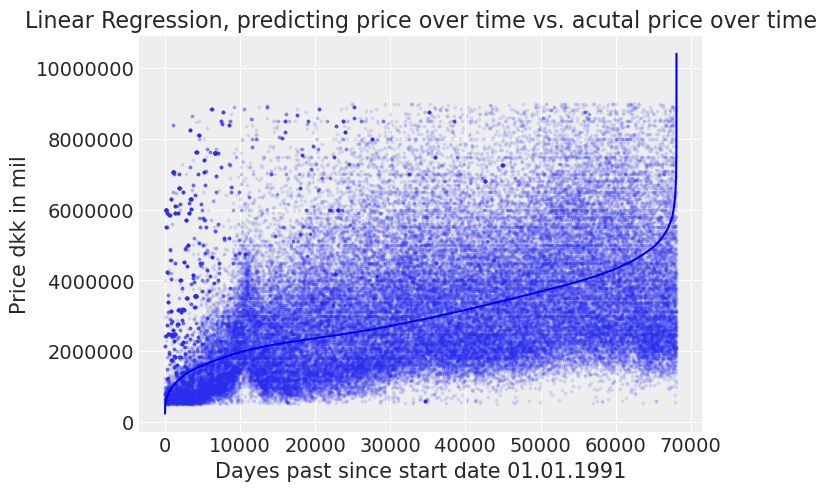

In [72]:
plt.plot(g.index, g.sort_values(by="y_pred")["y_pred"], c='b')
plt.scatter(g.index,g['price'],alpha=.1, s=3)
plt.ylabel('Price dkk in mil')
plt.xlabel('Dayes past since start date 01.01.1991')
plt.title('Linear Regression, predicting price over time vs. acutal price over time')
plt.ticklabel_format(axis='y', style='plain')
plt.show()